In [113]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report, f1_score, log_loss, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

from termcolor import colored
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [180]:
## Read csvs
train_df = pd.read_csv('../input/data-with-dates/train_x.csv', index_col=0)
test_df = pd.read_csv('../input/data-with-dates/test_ml_v2.csv', index_col=0)


# Data preprocessing

### Getting rid off outliers 

In [181]:
#Images, urls, chars_in_subject and chars_in_body contain outliers. 
#It can be verified comparing the max and mean for these features when running this script.

train_df.describe(include='all',datetime_is_numeric=True)
test_df.describe(include='all',datetime_is_numeric=True)

,weekday,day_number,month,time,time_continu,schedule,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body
count,17002,17002.000000,17002,17002,17002.000000,17002,16239,16239,17002.000000,17002.000000,16964,17002.000000,17002.000000,17002.000000,17002.000000,16998.000000,1.700200e+04
unique,8,NaN,12,14660,NaN,3,729,223,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN
top,Tue,NaN,oct,06:20:00,NaN,Morning,iiitd,com,NaN,NaN,multipart/alternative,NaN,NaN,NaN,NaN,NaN,NaN
freq,2895,NaN,1814,60,NaN,6817,3850,7525,NaN,NaN,12016,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,15.532526,NaN,NaN,12.054926,NaN,NaN,NaN,0.412893,0.003529,NaN,13.937654,36.552523,0.395483,0.101047,52.535416,2.073779e+05
std,NaN,8.822447,NaN,NaN,6.044946,NaN,NaN,NaN,3.299702,0.059302,NaN,666.067938,77.050638,0.488969,0.301400,36.123858,1.833055e+06
min,NaN,1.000000,NaN,NaN,0.001111,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00
25%,NaN,8.000000,NaN,NaN,7.685556,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,4.000000,0.000000,0.000000,31.000000,4.664000e+03
50%,NaN,15.000000,NaN,NaN,12.142222,NaN,NaN,NaN,0.000000,0.000000,NaN,2.000000,18.000000,0.000000,0.000000,43.000000,1.966650e+04
75%,NaN,23.000000,NaN,NaN,16.608264,NaN,NaN,NaN,0.000000,0.000000,NaN,9.000000,47.000000,1.000000,0.000000,64.000000,4.893625e+04


In [182]:
train_df[train_df['images']>70].groupby(['images']).count() #Show how much data contains above 70 images. 

#This helps for fixing thresholds in the code below.

,weekday,day_number,month,time,time_continu,schedule,org,tld,ccs,bcced,...,chars_in_subject,chars_in_body,updates,personal,promotions,forums,purchases,travel,spam,social
images,,,,,,,,,,,,,,,,,,,,,
71,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
72,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
73,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
74,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
75,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
78,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
79,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
80,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
81,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [183]:
n,m = train_df.shape[0], test_df.shape[0]

for i in range(n):
    if train_df.loc[i,'images']>=70:  #concerne 47 data : If the number of images is greater than 70, we consider it as outliers and replace them by the value of 70.
        train_df.loc[i,'images'] = 70
    if train_df.loc[i,'urls']>=250:   #concernce 104 data
        train_df.loc[i,'urls'] = 250
    if train_df.loc[i,'chars_in_subject']>=220:
        train_df.loc[i,'chars_in_subject'] = 220  #concerne 62 data
    if train_df.loc[i,'chars_in_body']>=1e5:
        train_df.loc[i,'chars_in_body'] = 1e5  #concerne 3419 data

#Same for test dataset

for i in range(m):
    if test_df.loc[i,'images']>=70:  
        test_df.loc[i,'images'] = 70
    if test_df.loc[i,'urls']>=250:   
        test_df.loc[i,'urls'] = 250
    if test_df.loc[i,'chars_in_subject']>=220:
        test_df.loc[i,'chars_in_subject'] = 220  
    if test_df.loc[i,'chars_in_body']>=1e5:
        test_df.loc[i,'chars_in_body'] = 1e5  

In [184]:
### Transforming Weekday, month and schedule into integers in order not to OneHotEncode them and not increasing number of features

combine = [train_df, test_df]

#Change weekday to numbers 0 for None 1 for Monday 7 for Sunday

days = {'None':0,'Mon':1, 'Tue':2, 'Wed':3, 'Thu':4, 'Fri':5, 'Sat':6, 'Sun':7}

#Change month to number 0 for january 11 for december    

Month = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7,'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}

#Change schedule to number

schedule_mapping = {"Morning": 1, "Afternoon": 2, "Night": 3}
for dataset in combine:
    dataset['schedule'] = dataset['schedule'].map(schedule_mapping)
    dataset['schedule'] = dataset['schedule'].fillna(0)
    dataset['weekday'] = dataset['weekday'].map(days)
    dataset['weekday'] = dataset['weekday'].fillna(0)
    dataset['month'] = dataset['month'].map(Month)
    dataset['month'] = dataset['month'].fillna(0)
    
print(train_df.shape)
train_df.head()

(39671, 25)


,weekday,day_number,month,time,time_continu,schedule,org,tld,ccs,bcced,...,chars_in_subject,chars_in_body,updates,personal,promotions,forums,purchases,travel,spam,social
Id,,,,,,,,,,,,,,,,,,,,,
0,1,15,10,08:03:09,8.052500,1,researchgatemail,net,0,0,...,47.0,25556,0,1,0,0,0,0,0,1
1,4,17,4,09:12:33,9.209167,1,no-ip,com,0,0,...,46.0,19930,1,1,0,0,0,0,0,0
2,4,27,10,01:36:28,1.607778,3,mail,goodreads.com,0,0,...,21.0,4,0,1,0,0,0,0,0,1
3,5,16,10,08:06:31,8.108611,1,insideapple,apple.com,0,0,...,52.0,96568,0,0,1,0,0,0,0,0
4,4,2,7,10:16:46,10.279444,1,twitter,com,0,0,...,81.0,95131,0,1,0,0,0,0,0,1


## Adding some new features

In [185]:
# We add new features

#categories images

n,m = train_df.shape[0], test_df.shape[0]
images_class_train, images_class_test = np.zeros((n,1)) , np.zeros((m,1))
for i in range(n):
    if train_df.loc[i,'images']==0:
        images_class_train[i,0] = 0
    elif train_df.loc[i,'images']>=70:   #Above 70 images, all data belong to the same category "10"
        images_class_train[i,0] = 10  
    else: 
        images_class_train[i,0] = (np.floor(train_df.loc[i,'images']*0.1)+1)  #numéro de classe correspondant au chifre de la dizaine +1 : exemple pour 32 images appartient à la classe 4.

for i in range(m):
    if test_df.loc[i,'images']==0:
        images_class_test[i,0] = 0
    elif test_df.loc[i,'images']>=70:
        images_class_test[i,0] = 10  
    else: 
        images_class_test[i,0] = (np.floor(test_df.loc[i,'images']*0.1)+1)
        
train_df['images_class'] = images_class_train
test_df['images_class'] = images_class_test

#categories chars_in_subject

subject_class_train, subject_class_test = np.zeros((n,1)) , np.zeros((m,1))
for i in range(n):
    if train_df.loc[i,'chars_in_subject']==0:
        subject_class_train[i,0] = 0
    elif train_df.loc[i,'chars_in_subject']>=90: #Above 90, all data belong to the same category "10"
        subject_class_train[i,0] = 10  
    else: 
        subject_class_train[i,0] = (np.floor(train_df.loc[i,'chars_in_subject']*0.1)+1)  #Between 0 and 90 : numéro de classe correspondant au chifre de la dizaine +1 : exemple : si 32 chars appartient à la classe 4.

for i in range(m):
    if test_df.loc[i,'chars_in_subject']==0:
        subject_class_test[i,0] = 0
    elif test_df.loc[i,'chars_in_subject']>=90:
        subject_class_test[i,0] = 10  
    else: 
        subject_class_test[i,0] = (np.floor(test_df.loc[i,'chars_in_subject']*0.1)+1)
        
train_df['chars_in_subject_class'] = subject_class_train
test_df['chars_in_subject_class'] = subject_class_test

# categories chars_in_body

body_class_train, body_class_test = np.zeros((n,1)) , np.zeros((m,1))
for i in range(n):
    if train_df.loc[i,'chars_in_body']>=1e5:
        body_class_train[i,0] = 20  
    else: 
        body_class_train[i,0] = train_df.loc[i,'chars_in_body']//5000  #Tranche de 5000 en 5000 jusqu'à 100 000.

for i in range(m):
    if test_df.loc[i,'chars_in_body']>=1e5:
        body_class_test[i,0] = 20  
    else: 
        body_class_test[i,0] = test_df.loc[i,'chars_in_body']//5000
        
train_df['chars_in_body_class'] = body_class_train
test_df['chars_in_body_class'] = body_class_test

# create categories of time 


bins = [k for k in range(25)]
group_names = [k for k in range(24)]
time_class = pd.cut(train_df['time_continu'], bins, labels=group_names)
train_df['time_class'] = pd.cut(train_df['time_continu'], bins, labels=group_names)

test_df['time_class'] = pd.cut(test_df['time_continu'], bins, labels=group_names)

test_df

,weekday,day_number,month,time,time_continu,schedule,org,tld,ccs,bcced,...,images,urls,salutations,designation,chars_in_subject,chars_in_body,images_class,chars_in_subject_class,chars_in_body_class,time_class
0,4,13,7,08:55:57,8.932500,1,twitter,com,0,0,...,7,56,0,0,67.0,36243,1.0,7.0,7.0,8
1,7,30,9,14:42:12,14.703333,2,mailer,netflix.com,0,0,...,5,33,0,0,27.0,27015,1.0,3.0,5.0,14
2,1,13,2,10:47:00,10.783333,1,iiitd,ac.in,0,0,...,0,2,1,0,22.0,788,0.0,3.0,0.0,10
3,4,16,6,09:56:23,9.939722,1,twitter,com,0,0,...,8,53,0,0,79.0,39504,1.0,8.0,7.0,9
4,1,18,4,01:51:59,1.866389,3,iiitd,ac.in,0,0,...,0,0,0,0,24.0,100000,0.0,3.0,20.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16997,2,2,6,12:23:54,12.398333,1,github,com,1,0,...,0,8,0,0,73.0,2372,0.0,8.0,0.0,12
16998,5,5,10,12:31:00,12.516667,1,mails,travel-makemytrip.com,0,0,...,7,27,0,0,39.0,13674,1.0,4.0,2.0,12
16999,4,3,10,14:42:24,14.706667,2,gmail,com,0,0,...,0,0,0,0,25.0,19845,0.0,3.0,3.0,14
17000,3,15,1,09:02:07,9.035278,1,standupalice,com,0,0,...,1,6,0,0,39.0,17565,1.0,4.0,3.0,9


## Reducing number of future encoded features

In [186]:
T =50  #minimum frequency for one category to be kept. Otherwise, this category would be replaced by a new category 'Rare'

# We do this process for org, tld and mail_type on train dataset

print('org',40*'-')
org_train_all = train_df['org'].value_counts()
print('Before',len(org_train_all)) #number of features before placing rare categories into another category.
org_train_del = train_df['org'].value_counts()[train_df['org'].value_counts()< T].index
print('After',len(org_train_all)-len(org_train_del))
print('tld',40*'-')
tld_train_all = train_df['tld'].value_counts()
print('Before',len(tld_train_all))
tld_train_del = train_df['tld'].value_counts()[train_df['tld'].value_counts()< T].index
print('After',len(tld_train_all)-len(tld_train_del))
print('mail_type',40*'-')
mail_type_train_all = train_df['mail_type'].value_counts()
print('Before',len(mail_type_train_all))
mail_type_train_del = train_df['mail_type'].value_counts()[train_df['mail_type'].value_counts()< T].index
print('After',len(mail_type_train_all)-len(mail_type_train_del))

#Same for test dataset

print( "="*40, 'test')
print('org',40*'-')
org_test_all = test_df['org'].value_counts()
print('Before',len(org_test_all))
org_test_del = test_df['org'].value_counts()[test_df['org'].value_counts()< T].index
print('After',len(org_test_all)-len(org_test_del))
print('tld',40*'-')
tld_test_all = test_df['tld'].value_counts()
print('Before',len(tld_test_all))
tld_test_del = test_df['tld'].value_counts()[test_df['tld'].value_counts()< T].index
print('After',len(tld_test_all)-len(tld_test_del))
print('mail-type',40*'-')
mail_type_test_all = test_df['mail_type'].value_counts()
print('Before',len(mail_type_test_all))
mail_type_test_del = test_df['mail_type'].value_counts()[test_df['mail_type'].value_counts()< T].index
print('After',len(mail_type_test_all)-len(mail_type_test_del))

#Place the categories into a new category 'Rare'

train_df['org'] = train_df['org'].replace(org_train_del, 'Rare')
train_df['tld'] = train_df['tld'].replace(tld_train_del, 'Rare')
train_df['mail_type'] = train_df['mail_type'].replace(mail_type_train_del, 'Rare')

test_df['org'] = test_df['org'].replace(org_test_del, 'Rare')
test_df['tld'] = test_df['tld'].replace(tld_test_del, 'Rare')
test_df['mail_type'] = test_df['mail_type'].replace(mail_type_test_del, 'Rare')



org ----------------------------------------
Before 973
After 103
tld ----------------------------------------
Before 271
After 41
mail_type ----------------------------------------
Before 14
After 5
======================================== test
org ----------------------------------------
Before 729
After 48
tld ----------------------------------------
Before 223
After 19
mail-type ----------------------------------------
Before 10
After 5


## Data preparation

In [187]:
train_y = train_df[['updates', 'personal', 'promotions','forums', 'purchases', 'travel','spam', 'social']]

# We gather numerical features and fill by 0 if there is no value

train_x_1 = train_df[['weekday','day_number','month','time_continu', 'schedule', 'ccs', 'bcced', 'images', 'urls',
       'salutations', 'chars_in_subject', 'chars_in_body','images_class','chars_in_subject_class', 'chars_in_body_class','time_class']]
train_x_1 = train_x_1.fillna(value=0)

test_x_1 = test_df[['weekday','day_number','month','time_continu', 'schedule', 'ccs', 'bcced', 'images', 'urls',
       'salutations', 'chars_in_subject', 'chars_in_body','images_class','chars_in_subject_class', 'chars_in_body_class','time_class']]
test_x_1 = test_x_1.fillna(value=0)

# We gather categorical features and fill by None if there is no value

train_x_obj = train_df[['mail_type','tld','org']]
train_x_obj = train_x_obj.fillna(value='None')

test_x_obj = test_df[['mail_type','tld','org']]
test_x_obj = test_x_obj.fillna(value='None')

### Encoding categorical features

In [191]:
## Do one hot encoding of categorical features
feat_enc = OneHotEncoder()
feat_enc.fit(np.vstack([train_x_obj, test_x_obj])) #np.vstack concatène train_x and test_x
train_x_featurized = feat_enc.transform(train_x_obj)  
test_x_featurized = feat_enc.transform(test_x_obj)

print('number of encoded features ', train_x_featurized.shape[1])

number of encoded features  155


### Processing numerical features

<AxesSubplot:>

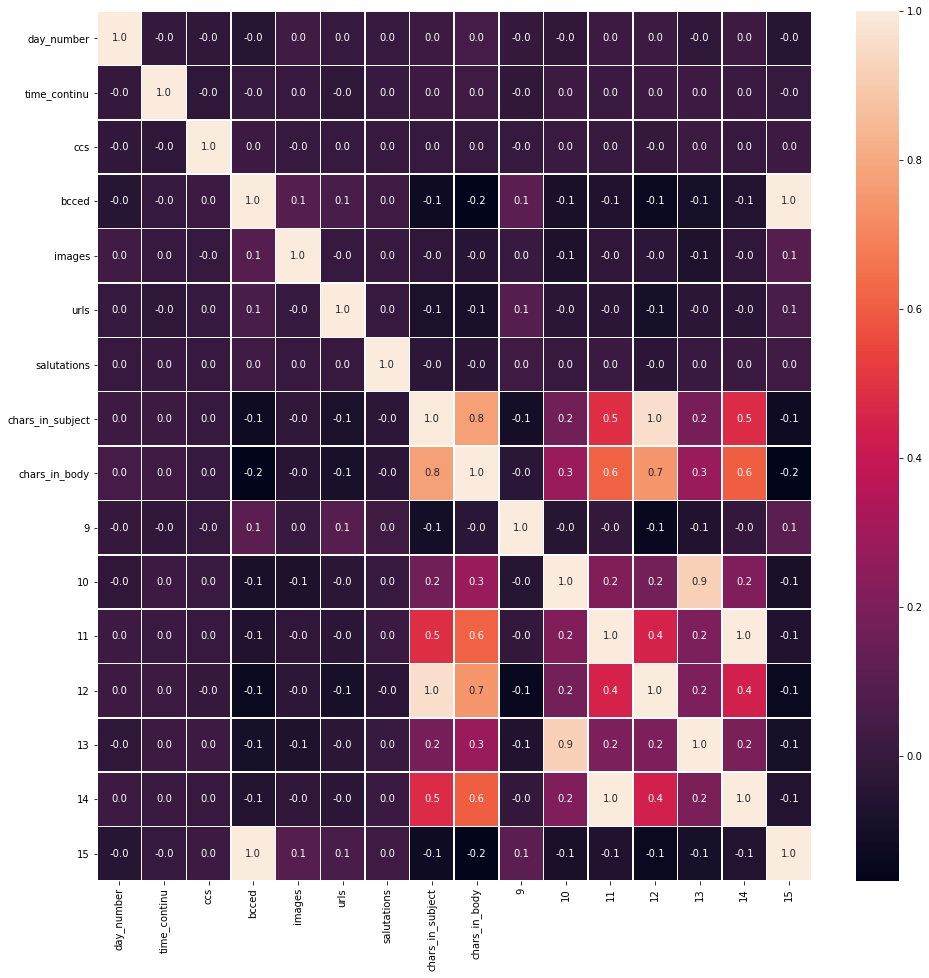

In [192]:
n = train_x_1.shape[1]
f,ax = plt.subplots(figsize=(n, n))
sb.heatmap(train_x_1.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### Some correlations appear between urls / images / chars_in_body because of the step 1 where we got rid of outliers.

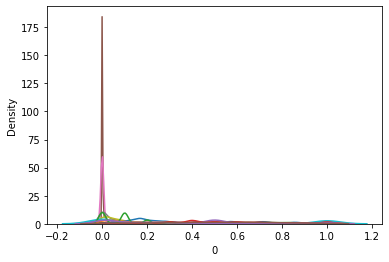

In [195]:
# SCALING for numerical features

Scaler=MinMaxScaler()
Scaler.fit(np.vstack([train_x_1, test_x_1]))  #We fit the scaler on both the train and test datasets.

train_x_1 = pd.DataFrame(Scaler.transform(train_x_1))
test_x_1 = pd.DataFrame(Scaler.transform(test_x_1))


for feature in test_x_1.columns:
    sb.kdeplot(test_x_1[feature])

### Concatenating numerical and encoded features

In [194]:
#Gather all features in one dataset with encoded object features
train_x_2 = pd.DataFrame(train_x_featurized.toarray())  #convert scarse matrix to df
train_x_all = np.concatenate((train_x_1,train_x_2),axis=1)

test_x_2 = pd.DataFrame(test_x_featurized.toarray())  #convert scarse matrix to df
test_x_all = np.concatenate((test_x_1, test_x_2),axis=1)

# Train - test split

In [132]:
# # We use 8 classifiers, one for each label and we then gather all predictions in one array called "Total_pred".
# def split_score(train_x, train_y, clf1, clf2):
#     labels = ['updates','personal', 'promotions', 'forums', 'purchases', 'travel', 'spam', 'social']
#     Total_pred = np.array([]).reshape(7935,0)
#     Total_y = np.array([]).reshape(7935,0)
    
#     for i,label in enumerate(labels):
#         x_train, x_test, y_train, y_test = train_test_split(train_x,train_y[label],test_size=0.20,shuffle=False)
#         print(i, label)
        
#         if i<4:      # label is updates, personal, promotions or forums :The 4 most difficult label to classify
#             xg = clf1.fit(x_train, y_train)
            
#         else :      # The last 4 labels are way much easier to classify.
#             xg = clf2.fit(x_train, y_train)
            
#         pred = xg.predict(x_test)
#         print(pred)
#         print(accuracy_score(y_train, xg.predict(x_train)))
#         print(accuracy_score(y_test, pred))
#         pred = pred.reshape((-1,1))
#         y_test = y_test.to_numpy().reshape((-1,1))
#         Total_pred = np.hstack((Total_pred, pred)) #concatenate prediction for each label
#         Total_y = np.hstack((Total_y, y_test))
#         print(Total_y.shape)
#         print(40*'--')    
        
#     return Total_y, Total_pred

In [133]:
# Total_y, Total_pred = split_score(train_x_all, train_y, RandomForestClassifier(n_estimators=200,n_jobs=-1),RandomForestClassifier(n_estimators=100 ,n_jobs=-1))
# log_loss(Total_y, Total_pred)
# accuracy_score(Total_y, Total_pred)

0 updates
[0.115 0.99  0.665 ... 0.    0.58  0.945]
1.0
(7935, 1)
--------------------------------------------------------------------------------
1 personal
[0.92  1.    0.955 ... 1.    0.98  0.36 ]
1.0
(7935, 2)
--------------------------------------------------------------------------------
2 promotions
[0.07  0.    0.005 ... 0.    0.39  0.   ]
1.0
(7935, 3)
--------------------------------------------------------------------------------
3 forums
[0.015 0.    0.195 ... 0.485 0.    0.02 ]
1.0
(7935, 4)
--------------------------------------------------------------------------------
4 purchases
[0.   0.   0.   ... 0.   0.   0.01]
1.0
(7935, 5)
--------------------------------------------------------------------------------
5 travel
[0. 0. 0. ... 0. 0. 0.]
1.0
(7935, 6)
--------------------------------------------------------------------------------
6 spam
[0. 0. 0. ... 0. 0. 0.]
1.0
(7935, 7)
--------------------------------------------------------------------------------
7 social
[0.

# Test Submission

In [176]:
# We use 8 xgboost algorithms, one for each label and we then gather all prediction in one array called "Total_pred".

#### If you have enough computing power, feel free to increase the n_estimators up to 1000. ####

labels = ['updates','personal', 'promotions', 'forums', 'purchases', 'travel', 'spam', 'social']
Total_pred = np.array([]).reshape(17002,0)

for i,label in enumerate(labels):
    print(i, label)
    if i<4:    # label is updates, personal, promotions or forums : The 4 most difficult label to classify
        xg = XGBClassifier(n_estimators=200,max_depth=10, n_jobs=-1).fit(train_x_all, train_y[label])
    
    else : # The last 4 labels are way much easier to classify. 
        xg = XGBClassifier(n_estimators=30, n_jobs=-1).fit(train_x_all, train_y[label])
        
    pred = xg.predict_proba(test_x_all)
    print(pred)
    print(accuracy_score(train_y[label],xg.predict(train_x_all)))
    pred = pred[:,1].reshape((-1,1)
    Total_pred = np.hstack((Total_pred, pred))  #concatenate prediction for each label
    print(Total_pred.shape)


0 updates


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:44:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[9.9909562e-01 9.0438250e-04]
 [1.0127473e-01 8.9872527e-01]
 [9.9815732e-01 1.8427050e-03]
 ...
 [9.1605484e-01 8.3945170e-02]
 [9.9804682e-01 1.9532011e-03]
 [9.4695759e-01 5.3042423e-02]]
0.9812961609235966
(17002, 1)
1 personal
[20:51:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[1.19344890e-01 8.80655110e-01]
 [1.12140715e-01 8.87859285e-01]
 [3.42607498e-04 9.99657393e-01]
 ...
 [8.63447189e-02 9.13655281e-01]
 [9.99245286e-01 7.54728157e-04]
 [2.66802311e-03 9.97331977e-01]]
0.9889087746716745
(17002, 2)
2 promotions
[20:58:17] WARNI

In [177]:
## Save results to submission file
pred_df = pd.DataFrame(Total_pred, columns=['updates', 'personal', 'promotions',
                        'forums', 'purchases', 'travel',
                        'spam', 'social'])
pred_df.to_csv("wait_and_pray.csv", index=True, index_label='Id')
pred_df

,updates,personal,promotions,forums,purchases,travel,spam,social
0,0.000904,0.880655,0.001636,1.780435e-06,0.002710,0.000118,0.000079,0.985933
1,0.898725,0.887859,0.042747,6.885726e-07,0.001632,0.000442,0.001866,0.006416
2,0.001843,0.999657,0.000020,9.718705e-01,0.000217,0.000354,0.000106,0.000416
3,0.000645,0.968807,0.000085,6.877056e-06,0.000978,0.000128,0.000079,0.992514
4,0.000758,0.999522,0.000017,4.256177e-03,0.000570,0.000458,0.000081,0.000416
...,...,...,...,...,...,...,...,...
16997,0.001929,0.021430,0.000307,9.994573e-01,0.000610,0.000214,0.000079,0.001413
16998,0.068294,0.127526,0.982134,1.813672e-05,0.001088,0.000337,0.011055,0.008522
16999,0.083945,0.913655,0.000290,5.040340e-02,0.000786,0.000800,0.005792,0.002055
17000,0.001953,0.000755,0.000318,9.999334e-01,0.000692,0.000140,0.000079,0.001976


# More data exploration tools

In [ ]:
#Some bar charts to visually explore correlation between labels and features

grid = sb.FacetGrid(train_df, col='promotions')
grid.map(plt.hist, 'month', alpha=.5, bins=12)
grid.add_legend();
grid = sb.FacetGrid(train_df, col='updates')
grid.map(plt.hist, 'month', alpha=.5, bins=12)
grid.add_legend();
grid = sb.FacetGrid(train_df, col='personal')
grid.map(plt.hist, 'month', alpha=.5, bins=12)
grid.add_legend();

In [ ]:
#Some statistics to explore correlation between labels and features

binary_features = ['bcced','salutations','designation']
number_features = ['day_number','time_continu','images', 'urls', 'chars_in_body', 'chars_in_subject']
labels = ['updates', 'personal', 'promotions',
                        'forums', 'purchases', 'travel',
                        'spam', 'social']
for label in labels:
    print(colored(label,'red'))
    for feature in binary_features:
        stat_feature = train_df.loc[train_df[feature] == 1][label]
        rate = sum(stat_feature)/len(stat_feature)
        print("% of {} in {} : {}".format(feature, label, colored(round(rate,3),'blue')))
    for feature in number_features:
        general_mean = train_df[feature].mean()
        general_std = train_df[feature].std()
        mean = train_df.loc[train_df[label] == 1, feature].mean()  #mean of the feature where label is verified (==1)
        std = train_df.loc[train_df[label] == 1, feature].std()
        mean_n = train_df.loc[train_df[label] == 0, feature].mean()  #mean of the feature where label is verified (==1)
        std_n = train_df.loc[train_df[label] == 0, feature].std()
        print("{} in {} : relative + mean = {} relative + std = {} relative - mean = {} relative - std = {}".format(feature, label, colored(round(mean/general_mean,2),'green'),colored(round(std/general_std,2),'yellow'),colored(round(mean_n/general_std,2),'green'),colored(round(std_n/general_std,2),'yellow')))